# Creative Experiments: 

## 1. Genre Blending: Interpolate between Jazz and Rock

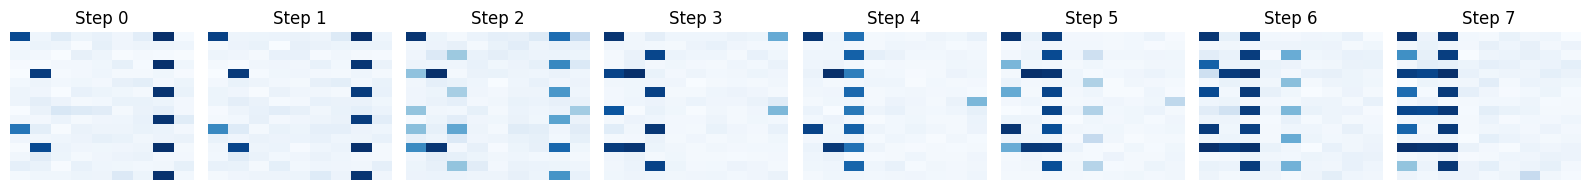

In [ ]:
import torch
from dataset import DrumPatternDataset
from hierarchical_vae import HierarchicalDrumVAE
from analyze_latent import interpolate_styles
import matplotlib.pyplot as plt

# Load model and data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HierarchicalDrumVAE(z_high_dim=4, z_low_dim=12)
model.load_state_dict(torch.load('results/best_model.pth', map_location=device))
model.to(device)
ds = DrumPatternDataset('..\\data\\drums', split='val')

# Find jazz and rock patterns
jazz_idx = next(i for i, (_, style, _) in enumerate(ds) if style == 1)
rock_idx = next(i for i, (_, style, _) in enumerate(ds) if style == 0)
jazz_pat = ds[jazz_idx][0]
rock_pat = ds[rock_idx][0]
jazz_pat = jazz_pat.to(device)
rock_pat = rock_pat.to(device)

# Interpolate
patterns = interpolate_styles(model, jazz_pat, rock_pat, n_steps=8, device=device)

# Plot
fig, axes = plt.subplots(1, 8, figsize=(16,2))
for i, pat in enumerate(patterns):
    pat = pat.squeeze()
    if isinstance(pat, torch.Tensor):
        pat = pat.detach().cpu().numpy()
    axes[i].imshow(pat, cmap='Blues', aspect='auto')
    axes[i].set_title(f'Step {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 2. Complexity Control: Latent Dimension Sweep for Density

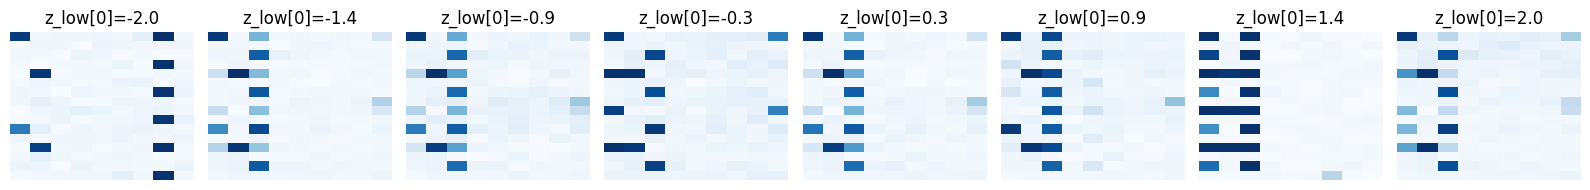

In [ ]:
import numpy as np
z_high = torch.randn(1, model.z_high_dim).to(device)
sweep_dim = 0
vals = np.linspace(-2, 2, 8)
fig, axes = plt.subplots(1, 8, figsize=(16,2))
for i, v in enumerate(vals):
    z_low = torch.randn(1, model.z_low_dim).to(device)
    z_low[0, sweep_dim] = v
    with torch.no_grad():
        logits = model.decode_hierarchy(z_high, z_low)
        pat = torch.sigmoid(logits).cpu().numpy().squeeze()
    axes[i].imshow(pat, cmap='Blues', aspect='auto')
    axes[i].set_title(f'z_low[{sweep_dim}]={v:.1f}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 3. Humanization: Add Controlled Variations to Mechanical Patterns

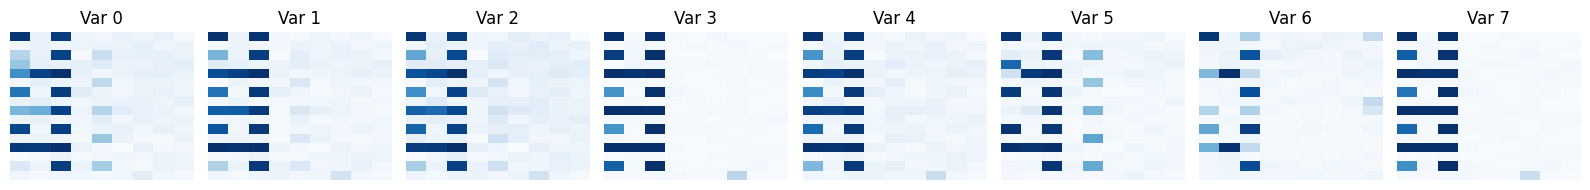

In [ ]:
# Humanization: Add Controlled Variations to Mechanical Patterns
z_high = torch.randn(1, model.z_high_dim).to(device)
z_low = torch.randn(1, model.z_low_dim).to(device)
fig, axes = plt.subplots(1, 8, figsize=(16,2))
for i in range(8):
    z_low_var = z_low + torch.randn_like(z_low) * 1.0  
    with torch.no_grad():
        logits = model.decode_hierarchy(z_high, z_low_var)
        pat = torch.sigmoid(logits).cpu().numpy().squeeze()
    axes[i].imshow(pat, cmap='Blues', aspect='auto')
    axes[i].set_title(f'Var {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 4. Style Consistency: Generate Full Drum Tracks with Fixed Style

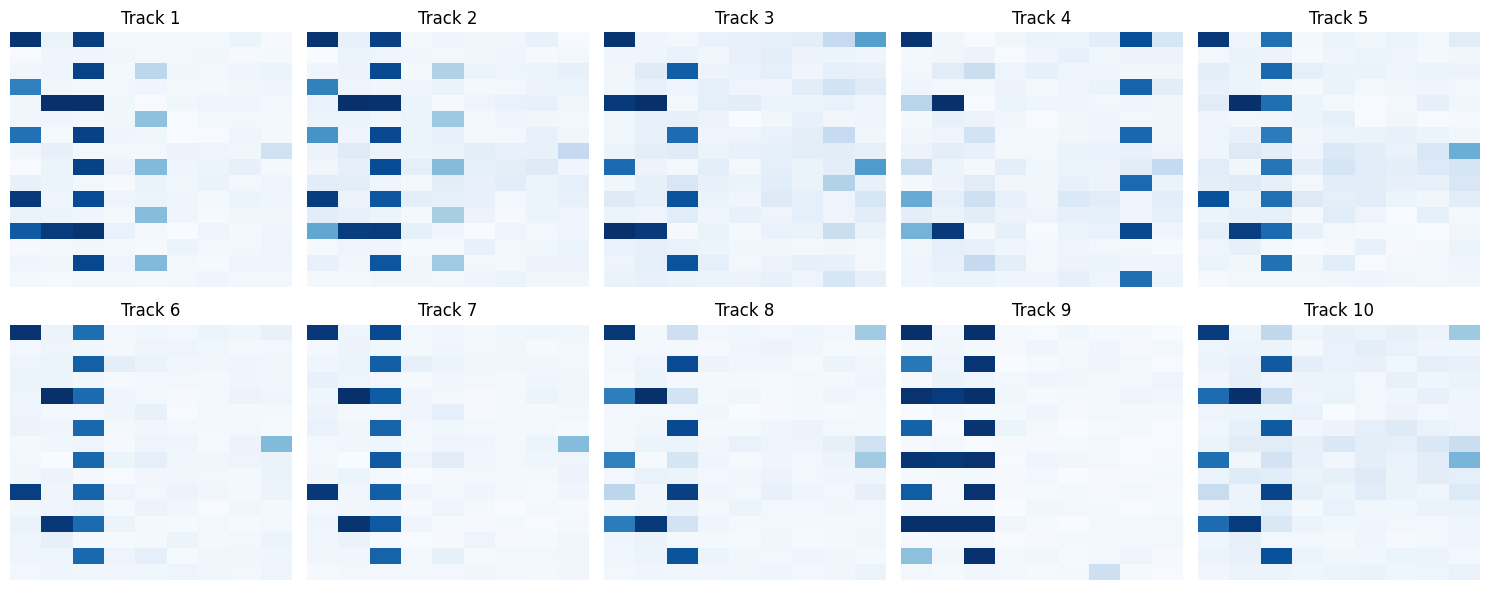

In [4]:
# Style Consistency: Generate Full Drum Tracks with Fixed Style
rock_z_high = torch.randn(1, model.z_high_dim).to(device)
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i in range(10):
    z_low = torch.randn(1, model.z_low_dim).to(device)
    with torch.no_grad():
        logits = model.decode_hierarchy(rock_z_high, z_low)
        pat = torch.sigmoid(logits).cpu().numpy().squeeze()
    row, col = divmod(i, 5)
    axes[row, col].imshow(pat, cmap='Blues', aspect='auto')
    axes[row, col].set_title(f'Track {i+1}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()